In [ ]:
import pandas as pd
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt

#PS: Pressure, bar, 100 Hz --> 100 Messungen pro Skeunde
#EPS: Motor power, W, 100 Hz
#FS: Volume flow, l/min, 10 Hz --> 10 Messungen pro Sekunde
#TS: Temperature, Celsius, 1 Hz --> 1 Messung pro Sekunde
#VS: Vibration, mm/s, 1Hz
#CE: Cooling efficiency (virtual), %, 1 Hz
#CP: Cooling power (virtual), kW, 1 Hz
#SE: Efficency factor, %, 1 Hz


input_path = "input_data/"
file_names = [
    "ce", "cp", "eps1", "se", "vs1", 
    "fs1", "fs2", 
    "ps1", "ps2", "ps3", "ps4", "ps5", "ps6",
    "ts1", "ts2", "ts3", "ts4", "target"
]

data = {}

for file_name in file_names:
    data[file_name] = loadtxt(f"{input_path}{file_name}.txt")

In [12]:
for file_name in file_names:
    print(f"Shape of {file_name}:{data[file_name].shape}")

Shape of ce:(2205, 60)
Shape of cp:(2205, 60)
Shape of eps1:(2205, 6000)
Shape of se:(2205, 60)
Shape of vs1:(2205, 60)
Shape of fs1:(2205, 600)
Shape of fs2:(2205, 600)
Shape of ps1:(2205, 6000)
Shape of ps2:(2205, 6000)
Shape of ps3:(2205, 6000)
Shape of ps4:(2205, 6000)
Shape of ps5:(2205, 6000)
Shape of ps6:(2205, 6000)
Shape of ts1:(2205, 60)
Shape of ts2:(2205, 60)
Shape of ts3:(2205, 60)
Shape of ts4:(2205, 60)
Shape of target:(2205, 5)


In [16]:
ps1_mean = data['ps1'].mean(axis=1)
ps1_mean

array([160.67349167, 160.60332   , 160.34772   , ..., 161.19212   ,
       161.20891667, 161.21712833])

In [ ]:
for key, array in data.items():
    print(f"{key}: Mean = {round((np.mean(array)),4)}, Std = {round((np.std(array)),4)}, Min = {np.min(array)}, Max = {np.max(array)}")


ce: Mean=31.2991, Std=11.5779, Min=17.042, Max=48.777
cp: Mean=1.8084, Std=0.2793, Min=1.016, Max=2.909
eps1: Mean=2495.5092, Std=218.2222, Min=2097.8, Max=2995.2
se: Mean=55.2879, Std=25.6422, Min=0.0, Max=100.6
vs1: Mean=0.6133, Std=0.0805, Min=0.483, Max=2.546
fs1: Mean=6.1985, Std=3.2138, Min=0.0, Max=20.479
fs2: Mean=9.6495, Std=0.4495, Min=8.764, Max=10.453
ps1: Mean=160.4853, Std=16.1333, Min=133.13, Max=191.92
ps2: Mean=109.3799, Std=48.1032, Min=0.0, Max=167.77
ps3: Mean=1.7532, Std=0.9347, Min=0.0, Max=18.828
ps4: Mean=2.6003, Std=4.2976, Min=0.0, Max=10.266
ps5: Mean=9.1633, Std=0.5766, Min=8.318, Max=10.041
ps6: Mean=9.0794, Std=0.5499, Min=8.268, Max=9.91
ts1: Mean=45.4246, Std=7.9925, Min=34.984, Max=58.207
ts2: Mean=50.366, Std=7.3956, Min=40.707, Max=62.176
ts3: Mean=47.6621, Std=7.4506, Min=38.145, Max=59.539
ts4: Mean=40.7357, Std=8.1063, Min=30.355, Max=53.145
target: Mean=48.0293, Std=49.1221, Min=0.0, Max=130.0


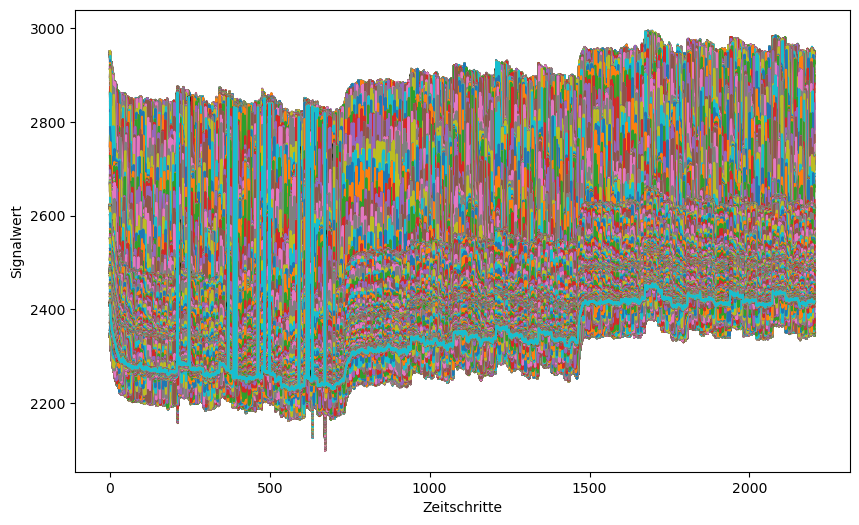

In [ ]:
# Beispiel: Visualisierung eines Signals
plt.figure(figsize=(10, 6))
plt.plot(data["eps1"])
#plt.title("Sensor: ce")
plt.xlabel("Zeitschritte")
plt.ylabel("Signalwert")
plt.show()

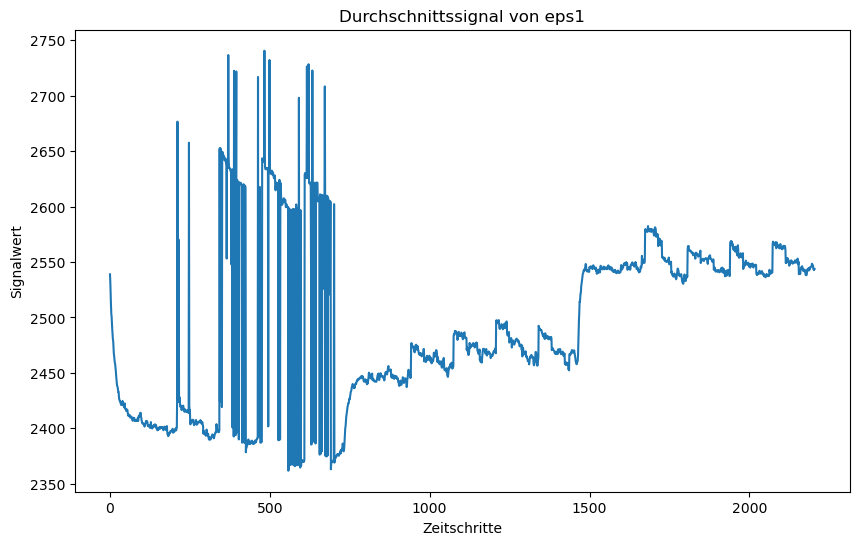

In [31]:
#Visualisierung eines Signals mit Durchschnittswert
mean_signal = np.mean(data["eps1"], axis=1)  # Durchschnitt über alle Spalten
plt.figure(figsize=(10, 6))
plt.plot(mean_signal)
plt.title("Durchschnittssignal von eps1")
plt.xlabel("Zeitschritte")
plt.ylabel("Signalwert")
plt.show()


In [35]:
file_path = 'input_data/EPS1.txt'

# Datei einlesen, Trennzeichen für Leerzeichen oder Tabulatoren anpassen
df = pd.read_csv(file_path, sep="\t", header=None)  # oder sep=" " für Leerzeichen

# DataFrame anzeigen
print(df.head())

     0       1       2       3       4       5       6       7       8     \
0  2411.6  2411.6  2411.6  2411.6  2411.6  2411.6  2411.6  2411.6  2411.6   
1  2409.6  2409.6  2409.6  2409.6  2409.6  2409.6  2409.6  2409.6  2409.6   
2  2397.8  2397.8  2397.8  2397.8  2397.8  2397.8  2397.8  2397.8  2397.8   
3  2383.8  2383.8  2383.8  2383.8  2383.8  2383.8  2383.8  2383.8  2382.8   
4  2372.0  2372.0  2372.0  2372.0  2372.0  2372.0  2372.0  2372.0  2372.0   

     9     ...    5990    5991    5992    5993    5994    5995    5996  \
0  2409.6  ...  2409.6  2409.2  2409.6  2409.4  2409.6  2409.4  2409.6   
1  2409.6  ...  2398.8  2398.2  2398.2  2398.0  2398.0  2398.0  2398.0   
2  2395.8  ...  2383.8  2383.8  2383.8  2383.8  2383.8  2383.8  2383.8   
3  2382.8  ...  2373.2  2372.8  2372.6  2372.4  2372.2  2372.0  2372.0   
4  2373.0  ...  2370.0  2370.0  2369.8  2369.8  2369.8  2369.8  2369.6   

     5997    5998    5999  
0  2409.6  2409.6  2409.6  
1  2397.8  2397.8  2397.8  
2  2383.